# Laboratório 2: Construindo Sistemas com IA Generativa

## Parte 1 - RAG de Documentos

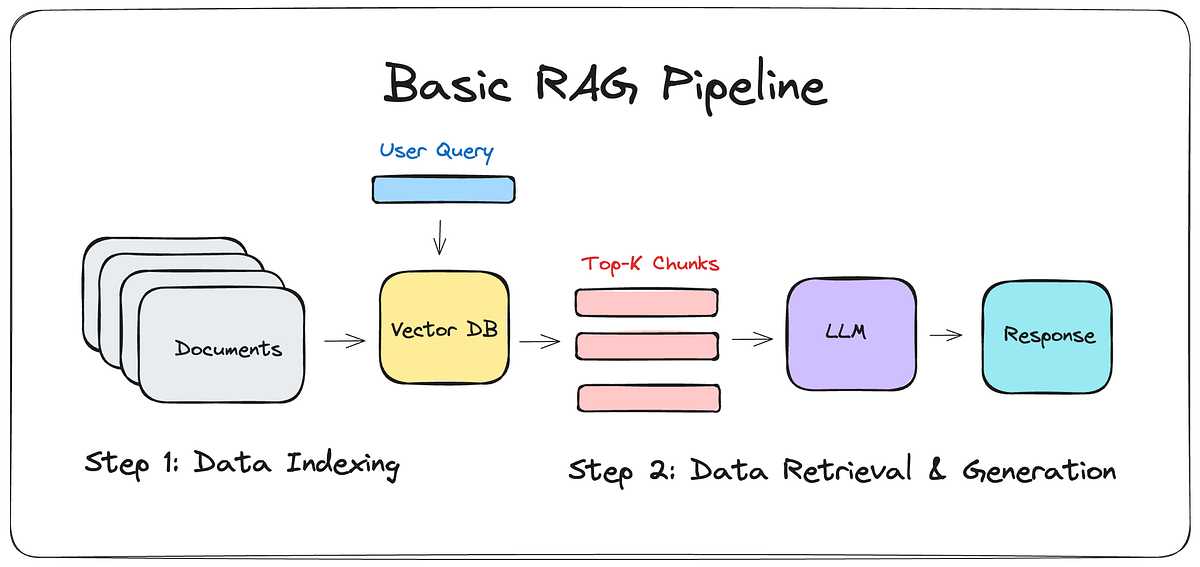

### 1. Interação LLM

In [ ]:
import os
from langchain_openai import ChatOpenAI
from IPython.display import Markdown
from dotenv import load_dotenv

# Carregando variáveis de ambiente
load_dotenv()

In [ ]:
# Criando interface para interagir com o modelo
model = ChatOpenAI(
    model="gpt-4o-mini",   # modelo leve e rápido
    temperature=0        # controla a criatividade da resposta
)

In [ ]:
# Fazendo uma pergunta simples ao modelo
resposta = model.invoke(
    "Quais as regras de lista de siglas para os trabalhos academicos da Academia Militar Marechal Samora Machel?"
    )
display(Markdown(resposta.content))

### 2. Quebra do documento em chunks

Vamos quebrar o documentos em partes menores *(chunks)* que possuem alguma sobreposição entre si. A ideia é selecionar alguns desses *chunks* de acordo com a pergunta do usuário para serem usados como base contextual para a LLM responder a pergunta

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

pdf_path = "normas-AM.pdf"

loader = PyPDFLoader(pdf_path)
docs = loader.load()

print(f"✅ Documento carregado com {len(docs)} páginas")

Limpeza de espaços em brancos das páginas

In [ ]:
import re

cleaned_docs = []
for d in docs:
    text = d.page_content
    # Remove múltiplas quebras de linha em sequência:
    text = re.sub(r'\n\s*\n+', '\n\n', text)
    # Remove espaços em branco no início/fim:
    text = text.strip()
    d.page_content = text
    cleaned_docs.append(d)
docs = cleaned_docs

In [ ]:
for d in docs:
    d.page_content = d.page_content.replace("\n\n\n", "\n\n")  # limpar quebras múltiplas
    # remover linhas que têm “Figura” ou “Tabela” se quiser
    d.page_content = "\n".join(
        line for line in d.page_content.splitlines()
        if not line.strip().startswith("Figura") and not line.strip().startswith("Tabela")
    )

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,      # número máximo de caracteres por chunk
    chunk_overlap=500,   # sobreposição entre chunks
    separators=["\n\n", "\n", ".", ""]  # ordem de prioridade na divisão
)

# Aplicar o splitter ao documento
chunks = text_splitter.split_documents(docs)

print(f"✅ Documento dividido em {len(chunks)} chunks")


In [ ]:
for i, chunk in enumerate(chunks[25:30]):
    print(f"\n--- Chunk {i+1} ---")
    print(chunk.page_content)  # mostrar apenas os primeiros 300 caracteres

### ✅ **Exercício**

- Altere o **chunk_size** e **chunk_overlap** e veja o impacto da alteração na visualização dos chunks


### 3. Vetorização de um chunk
Vamos usar um modelo de embedding para transformar o *chunk* em um vetor de 1536 dimensões que armazena um valor semântico daquele texto

In [ ]:
from langchain_openai import OpenAIEmbeddings
import numpy as np

# Inicializa o modelo de embeddings da OpenAI
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Seleciona um dos chunks gerados anteriormente
exemplo_chunk = chunks[20].page_content
print("📄 Texto do chunk:\n", exemplo_chunk[:300])


In [ ]:
# Gera o vetor de embedding para o chunk selecionado
vetor = embedding_model.embed_query(exemplo_chunk)

print(f"\n✅ Embedding gerado! O vetor tem {len(vetor)} dimensões.")
print("🔢 Primeiros 10 valores do vetor:\n", vetor[:10])


### 4. Banco vetorial (Chroma)
- Vamos criar **um embedding para cada chunk** e armazena-lo em um banco vetorial (Chroma). 

- Cada chunk será armazenado no banco como um **vetor + texto do trecho + metadado**
    - Obs: Esse metadado pode ser o nome do documento de origem, o nº da página do trecho, etc

- A ideia do banco é que poderemos fazer **buscas semânticas** utilzando **cálculos vetoriais** para selecionar os trechos do documento que estão **mais relacionados** com uma determinada pergunta do usuário

In [ ]:
from langchain_chroma import Chroma

collection_name = "normas-am"

vectorstore = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_model,
    persist_directory="./output/chroma_db" # Vamos persistir nossos dados em um banco sqlite na pasta chroma_db
)

In [ ]:
# Adiciona os documentos chunkados ao banco vetorial
vectorstore.add_documents(chunks)

print("✅ Todos os chunks foram vetorizados e armazenados no Chroma!")

In [ ]:
collection = vectorstore._client.get_collection(collection_name)

print(f"📊 O banco vetorial contém {collection.count()} embeddings.")

### 5. Busca semântica no Chroma
- Vamos fazer uma busca semântica dentro do banco vetorial. 

- Para isso, a pergunta do usuário *(query)* será vetorizada.

- Será feita uma busca de proximidade cossenoidal do vetor da pergunta com todos os outro vetores no banco.

In [ ]:
query = "Quais as regras de lista de siglas para os trabalhos academicos?"

num_chunks = 10
resultados = vectorstore.similarity_search(query, k=num_chunks)

print("🔎 Trechos mais relevantes encontrados:")
for i, r in enumerate(resultados):
    print(f"\n--- Resultado {i+1} ---")
    print(r.page_content[:300])

### ✅ **Exercício**

1. Teste a busca semântica para diferentes perguntas **(query)**

2. Ajuste o **num_chunks** para melhorar a completude a busca semântica

3. Ajuste o **chunk_size** e **chunk_overlap** para melhorar o ganho de informação através da busca semântica
    - Para essa tarefa será necessário deletar a collection criada no banco de dados vetorial (Chroma)
    - Para deletar a collection **descomente** a célula abaixo e rode.
    - Lembre de comentar a célula novamente para não deletar o banco de dados acidentalmente

In [ ]:

# FUNÇÃO PARA DELETAR O BANCO DE DADOS VETORIAL

# vectorstore.delete_collection()

### 6. Finalização do RAG

In [ ]:
def rag_module(pergunta: str, num_chunks: int = 5):
    chunks = vectorstore.similarity_search(query, k=num_chunks)
    contexto = "\n\n".join([r.page_content for r in chunks])

    prompt = f"""
        1- Você é um assistente especialista em responder perguntas com base no contexto em que lhe fornecido entre ===
        2- Use APENAS as informações abaixo para responder à pergunta.

        ===
        Contexto:
        {contexto}
        ===

        Pergunta: {pergunta}

        Responda de forma clara, concisa e cite os trechos do contexto quando possível.
    """

    resposta_final = model.invoke(prompt)

    return resposta_final


In [ ]:
pergunta = "Como deve ser feita a parte de lista de siglas?"

resposta = rag_module(pergunta, num_chunks=10)


print("\n💡 Resposta final do RAG:\n")

# Printar resposta
display(Markdown(resposta.content))

### 7. Propostas de melhoria

- **Refinar prompt:** Pedir para o LLM refinar a pergunta antes de fazer a busca vetorial, com o objetivo de obter chunks mais adequados

- **Estratégia de criação de chunks:** Usar outras estratégias para quebra do documento em chunks
    - Usar a estrutura do documento como referência (Ex: Em uma legislação quebrar um chunk por artigo)
    - Fazer quebra em chunks usando LLM para criar chunks que englobem totalmente uma ideia

- **Usar metadados dos chunks:** Os chunks possuem metadados associados. Geralmente inclui o nome da sua fonte de origem, autor, etc. Mas esse campo pode ser editado a critério do desenvolvedor.

- **Ferramentas de extração de texto:** O langchain possui funções que permitem você extrair o texto de outras tipos de fonte. Por exemplo:
    - **PyPDFLoader**: Extrai o texto de PDFs
    - **YoutubeAudioLoader**: Extrai a transcrição de vídeos do YouTube automaticamente
    - **WebBaseLoader**: Faz scraping de páginas, inclusive via sitemap
    - **WikipediaLoader**: Busca e extrai artigos diretamente da Wikipédia.


## Parte 2 - Agentes

### 1. Execução de funções

In [ ]:
# !pip install --upgrade \
#     langchain \
#     langchain-core \
#     langchain-community \
#     langchain-openai \
#     langchain-chroma \
#     langchain-ollama

In [ ]:
resposta = model.invoke("Quantas letras R tem a palavra CORREDOR?")
resposta.content


In [ ]:
from langchain_core.tools import Tool
from langchain.agents import initialize_agent
from langchain.agents.agent_types import AgentType
from langchain_core.prompts import PromptTemplate

In [ ]:
# 🧮 Função que conta quantas vezes uma letra aparece em uma palavra
def contar_letra(entrada: str) -> str:
    """
    Espera uma string no formato 'palavra letra'
    Exemplo: banana a
    """
    try:
        entrada = entrada.replace("'", "").replace('"', "")
        palavra, letra = entrada.split()
        contagem = palavra.lower().count(letra.lower())
        return f"A letra '{letra}' aparece {contagem} vez(es) na palavra '{palavra}'."
    except Exception as e:
        return f"Erro: forneça os dados no formato 'palavra letra'. Exemplo: 'banana a'"

# 🔧 Cria a tool com descrição para o agente entender
tools_exemplo = [
    Tool(
        name="Contador de letras",
        func=contar_letra,
        description="Conta quantas vezes uma letra específica aparece em uma palavra. Entrada esperada: 'palavra letra'."
    )
]

In [ ]:
# Cria o prompt base para o agente
prompt_template = PromptTemplate(
    input_variables=["input"],
    template="""
Você é um assistente que tem acesso a esta ferramenta:
{tools}

Respondendo à pergunta: {input}

Use a ferramenta quando for necessário.
"""
)

# 🧠 Cria o agente
agente_exemplo = initialize_agent(
    tools_exemplo,
    model,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

In [ ]:
resposta = agente_exemplo.invoke({"input": "Quantas letras R tem a palavra CORREDOR?"})
print("\n🤖 Resposta:", resposta["output"])


### 2. Busca no banco de dados

In [ ]:
# Banco simulado
usuarios = {
    "João": {"cargo": "Engenheiro de IA", "setor": "Pesquisa"},
    "Maria": {"cargo": "Analista de Dados", "setor": "Inteligência"},
}

# Função de consulta
def consultar_usuario(nome: str) -> str:
    dados = usuarios.get(nome)
    if not dados:
        return "Usuário não encontrado."
    return f"{nome} é {dados['cargo']} e trabalha no setor de {dados['setor']}."

# Tool de busca
tools_bd = [
    Tool(
        name="Consulta ao banco de dados de usuários",
        func=consultar_usuario,
        description="Fornece informações sobre um usuário registrado no banco interno."
    )
]

# Recria o agente
agente_bd = initialize_agent(
    tools_bd,
    model,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

In [ ]:
# Teste
resposta = agente_bd.invoke({"input": "Quem é João?"})
print("\n📊 Resposta:", resposta["output"])

### 4. Agente metereologico

In [ ]:
import requests

# ============================
# 🔹 Tool 1 — Busca coordenadas da cidade
# ============================
def buscar_coordenadas(cidade: str) -> str:
    """Busca latitude e longitude da cidade usando a API Nominatim (OpenStreetMap)."""
    url = f"https://nominatim.openstreetmap.org/search?q={cidade}&format=json&limit=1"
    headers = {"User-Agent": "LangChain-Agent-Demo"}
    
    r = requests.get(url, headers=headers)
    if not r.ok or not r.json():
        return "Não consegui encontrar coordenadas para essa cidade."
    
    dados = r.json()[0]
    lat, lon = dados["lat"], dados["lon"]
    return f"{cidade}: latitude={lat}, longitude={lon}"

# ============================
# 🔹 Tool 2 — Consulta clima via API Open-Meteo
# ============================
def clima_por_coordenadas(entrada: str) -> str:
    """Recebe uma string no formato 'latitude=X, longitude=Y' e retorna o clima atual."""
    try:
        partes = entrada.replace(",", "").split()
        lat = float(partes[0])
        lon = float(partes[1])
    except Exception as err:
        return f"Formato inválido. {err}"

    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true"
    r = requests.get(url)
    dados = r.json().get("current_weather", {})
    if not dados:
        return "Não foi possível obter dados climáticos."
    
    temperatura = dados["temperature"]
    vento = dados["windspeed"]
    return f"Temperatura: {temperatura}°C | Vento: {vento} km/h"

# ============================
# 🧰 Define as tools
# ============================
tools_web = [
    Tool(
        name="Buscar coordenadas da cidade",
        func=buscar_coordenadas,
        description="Retorna latitude e longitude de uma cidade."
    ),
    Tool(
        name="Consultar clima por coordenadas",
        func=clima_por_coordenadas,
        description="Dado latitude e longitude, retorna a temperatura e velocidade do vento."
    )
]


# Recria o agente
agente_metereologico = initialize_agent(
    tools_web,
    model,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)


In [ ]:
resposta = agente_metereologico.invoke({"input": "Qual é o clima em Nampula?"})
print("\n🌤️ Resultado:", resposta["output"])

### ✅ **Exercício**

1. Crie um agente que tenha como **tool** uma função de **RAG**

#### Possível solução (Tente fazer o exercício antes de abrir)

In [ ]:
def rag_module(pergunta: str, num_chunks: int = 5):
    """Responde a perguntas sobre as Normas dos trabalhos academicos da Academia Militar Marechal Samora Machel"""
    
    chunks = vectorstore.similarity_search(query, k=num_chunks)
    contexto = "\n\n".join([r.page_content for r in chunks])

    prompt = f"""
        1- Você é um assistente especialista em responder perguntas com base no contexto em que lhe fornecido entre ===
        2- Use APENAS as informações abaixo para responder à pergunta.

        ===
        Contexto:
        {contexto}
        ===

        Pergunta: {pergunta}

        Responda de forma clara, concisa e cite os trechos do contexto quando possível.
    """

    resposta_final = model.invoke(prompt)

    return resposta_final


tools_rag = [
    Tool(
        name="Responde a perguntas sobre o Normas de trabalhos academicos",
        func=rag_module,
        description="Responde a perguntas sobre as Normas dos trabalhos academicos da Academia Militar Marechal Samora Machel"
    )
]

agente_rag = initialize_agent(
    tools_rag,
    model,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

In [ ]:
resposta = agente_rag.invoke({"input": "Como deve ser feita a parte de lista de siglas?"})
display(Markdown(f"\nResultado: {resposta['output']}" ))


## Parte 3 - Modelos locais

Para rodar modelos locais utilizaremos a ferramenta chamada Ollama com o objetivo de interagir com o modelo Qwen3 com 4 Bilhões de parâmetros

In [ ]:
# !pip install -U langchain==0.2.16 langchain-core==0.2.38 langchain-ollama==0.1.1

In [ ]:
from langchain_ollama import ChatOllama

modelo_local = ChatOllama(model="qwen3", temperature=0.3)

In [ ]:
resposta = modelo_local.invoke("Quantas letras R tem a palavra CORREDOR?")
print(resposta.content)

### Interação com agentes usando modelo local

Agente de busca no banco de dados

In [ ]:
agente_bd = initialize_agent(
    tools_bd,
    modelo_local,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

# Teste
resposta = agente_bd.invoke({"input": "Quem é João?"})
print("\n📊 Resposta:", resposta["output"])

Agente de busca no metereologico

In [ ]:

agente_metereologico = initialize_agent(
    tools_web,
    model,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)


In [ ]:
resposta = agente_metereologico.invoke({"input": "Qual é o clima em Nampula?"})
print("\n🌤️ Resultado:", resposta["output"])